**Image Colorizing using GAN**

In [9]:
#GPU Test
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [118]:
#Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
import skimage.io
from skimage.io import imsave, imshow
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import h5py
import matplotlib.gridspec as gridspec
import cv2
from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from keras.layers import BatchNormalization,LeakyReLU,Flatten
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Model
from tensorflow.keras.models import load_model
from keras.optimizers import Adam
from google.colab import files
from keras import backend as K
import smtplib
from sklearn.utils import shuffle

In [10]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [119]:
# Versions
print('Tensorflow',tf.__version__)
print('Scikit-Image',skimage.__version__)
print('Keras',tf.keras.__version__)
print('Matplotlib',matplotlib.__version__)


2.4.1
0.16.2
2.4.0


In [13]:
DATA_PATH = '../content/gdrive/My Drive/img_data'
TRAIN = 'fimg'
TEST = 'test'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_PATH, TRAIN)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_PATH, TEST)))}")

Train samples: 1050
Test samples: 9


In [14]:
# Checking image types
train_list = list(os.listdir(os.path.join(DATA_PATH, TEST)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")

Extensions: ['jpg']


In [121]:
# Batch size
batch_size = 50

# Image size
img_size = 128

# Number of images for training
dataset_split = 1050

master_dir = '/content/gdrive/My Drive/img_data/fimg'

x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )

# RBG & Greyscale
train_x = np.array(x)
train_y = np.array(y)

X = tf.cast(train_x, tf.float32)
Y = tf.cast(train_y, tf.float32)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( X , Y ) )
dataset = dataset.batch( batch_size )

In [122]:
dataset

<BatchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>

**Generator architecture**

In [123]:

def gen_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    c1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 3 , 3 ) , strides=1 )( inputs )
    c1 = tf.keras.layers.LeakyReLU()( c1 )
    c1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( c1 )
    c1 = tf.keras.layers.LeakyReLU()( c1 )

    c2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1)( c1 )
    c2 = tf.keras.layers.LeakyReLU()( c2 )
    c2 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( c2 )
    c2 = tf.keras.layers.LeakyReLU()( c2 )

    c3 = tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1 )( c2 )
    c3 = tf.keras.layers.LeakyReLU()( c3 )

    bottleneck = tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' , padding='same' )( c3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , c3 ] )
    ct3 = tf.keras.layers.Conv2DTranspose( 256 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )

    concat_2 = tf.keras.layers.Concatenate()( [ ct3 , c2 ] )
    ct2 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    ct2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( ct2 )

    concat_3 = tf.keras.layers.Concatenate()( [ ct2 , c1 ] )
    ct1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    ct1 = tf.keras.layers.Conv2DTranspose( 16 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( ct1 )

    ct1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 1 , 1 ) , strides=1 , activation='relu')( ct1 )

    model = tf.keras.models.Model( inputs , ct1 )
    return model


**Discriminator Architecture**

In [124]:
def disc_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=2, input_shape=( 128 , 128 , 3 ) ),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 3, 3 ) , strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 256 , activation='relu' ),
        tf.keras.layers.Dense( 128 , activation='relu' ),
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model


**Loss Functions of Generator and Discriminator**

In [125]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mae = tf.keras.losses.MeanAbsoluteError()


def discriminator_loss(real_output, generated_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(gen_output , real_y, generated_output):
    gan_train_loss = cross_entropy(tf.ones_like(generated_output), generated_output)
    real_y = tf.cast( real_y , 'float32' )
    gan_result_loss = mae( gen_output , real_y )
    total_loss = gan_train_loss + (100*gan_result_loss)
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam( 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.001 )

generator = gen_model()
discriminator = disc_model()

In [ ]:
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

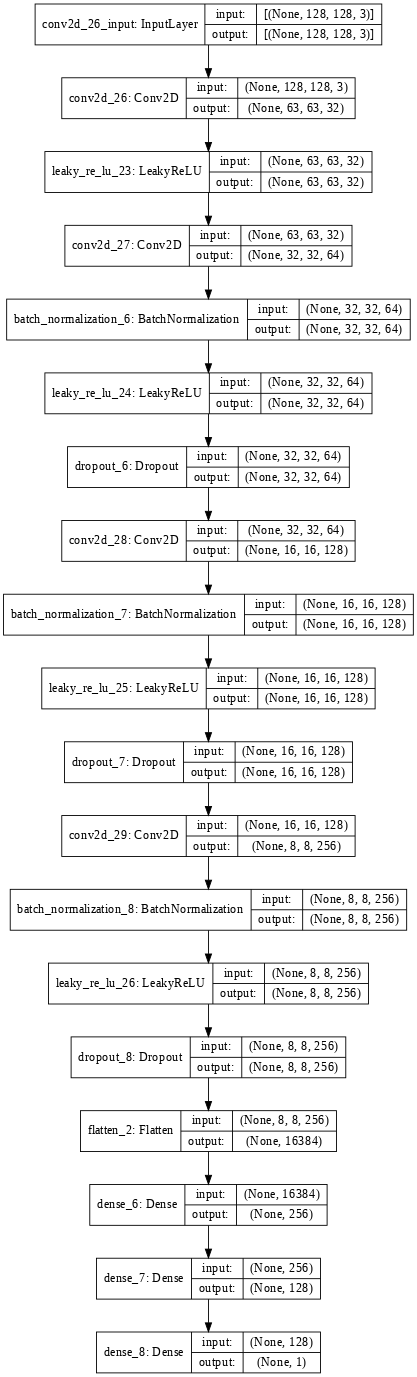

In [126]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

**Training Step**

In [127]:

@tf.function
def train_step( input_x , real_y ):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate training
        generated_images = generator( input_x , training=True)
        # Discriminator training
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated
        generated_output = discriminator(generated_images, training=True)
        
        # Calculate losses
        gen_loss = generator_loss( generated_images , real_y, generated_output)
        disc_loss = discriminator_loss( real_output, generated_output )
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [128]:

epochs = 200
g_loss = []
d_loss = []


for e in range(epochs):
    print( 'Epoch: ', e )
    for ( grey , rgb ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( grey.shape )
        g_l, d_l = train_step( grey , rgb )
    g_loss.append(g_l)
    d_loss.append(d_l)
    
    


Epoch:  0
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)
(50, 128, 128, 1)


**Loss Graphs**

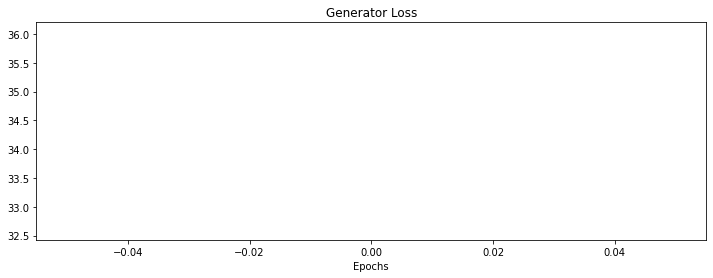

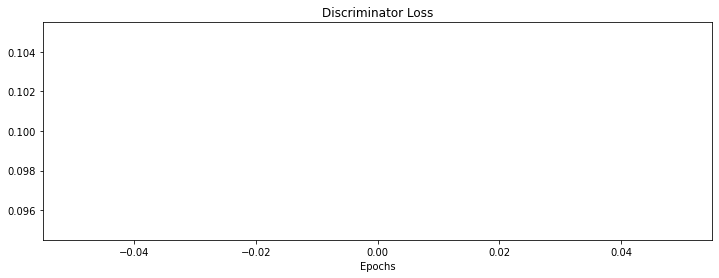

In [129]:
plt.figure(figsize=(12, 4))
plt.title('Generator Loss')
plt.xlabel('Epochs')
plt.plot(g_loss)


plt.figure(figsize=(12, 4))
plt.title('Discriminator Loss')
plt.xlabel('Epochs')
plt.plot(d_loss)

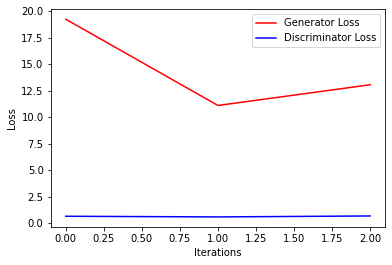

In [103]:
plt.plot(g_loss, c='r', label="Generator Loss")
plt.plot(d_loss, c='b', label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Test**

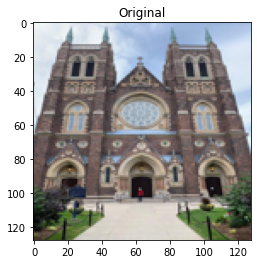

In [107]:
img1_color = []
test_dir = '/content/gdrive/My Drive/img_data/test'
test_image = Image.open( os.path.join( test_dir , 'im4.jpg') ).resize( ( img_size , img_size ) )
plt.title('Original')
plt.imshow(test_image)


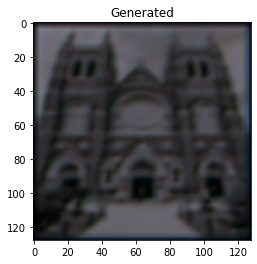

In [108]:
img1=img_to_array(test_image)
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))
y = generator(img1_color).numpy()

image = Image.fromarray( ( y[0] ).astype( 'uint8' ) )
image = np.asarray( image )
plt.imshow( image )
plt.title('Generated')
plt.show()

**Saving Model**

In [ ]:
generator.save_weights('/content/gdrive/My Drive/img_data/saves/gen_weights.h5')
discriminator.save_weights('/content/gdrive/My Drive/img_data/saves/dis_weights.h5')

In [ ]:
generator.load_weights('/content/gdrive/My Drive/img_data/saves/gen_weights.h5')
discriminator.load_weights('/content/gdrive/My Drive/img_data/saves/dis_weights.h5')

***Final model for deployment***

In [114]:
generator.save('/content/gdrive/My Drive/img_data/saves/generatorx.h5')

In [115]:
generatorx = tf.keras.models.load_model('/content/gdrive/My Drive/img_data/saves/generatorx.h5')

In [116]:
generatorx.compile()

In [117]:
# Show the model architecture
generatorx.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 126, 126, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 126, 126, 16) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 124, 124, 32) 4640        leaky_re_lu_9[0][0]              
____________________________________________________________________________________________